# Importing Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial
from itertools import chain

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, pmap, random, lax, value_and_grad, tree_multimap, tree_map, devices
import jax.example_libraries.optimizers as jeo

import time
from tqdm import tqdm

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

In [3]:
num_mach = 1

# Prior Functions

In [4]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [5]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

# Test Data

In [6]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [7]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [8]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 4.0
batch_size = 1
num_filt = num_mach * batch_size

# Maximum index of input data
n = np.floor(x_maxt/time_bin).astype(np.int64)
narr = jnp.asarray([n, n, n])

ytime = np.linspace(0.0, x_maxt, n + 1).reshape(n + 1, 1)

spikedat1 = random.bernoulli(subkeyx, 0.1, (num_filt * (n + 1),)).astype(np.float64).reshape(num_filt, n + 1, 1)
spikedat2 = random.bernoulli(subkeys[-2], 0.1, (num_filt * (n + 1),)).astype(np.float64).reshape(num_filt, n + 1, 1)
spikedat3 = random.bernoulli(subkeys[-3], 0.1, (num_filt * (n + 1),)).astype(np.float64).reshape(num_filt, n + 1, 1)

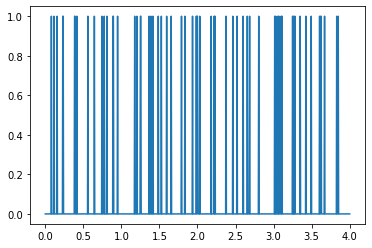

In [9]:
plt.plot(ytime, spikedat2.flatten())

### True Filter

In [10]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 1.0

# Maximum index of filter data
k = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, k + 1).reshape(k + 1, 1)

# Damped frequency
w_d = 18.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.09)

# Sqrt True diff
tau_diff = np.sqrt(0.001)

# True lag
lag = 0.05

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = (np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))) * env_true).reshape(k + 1, 1)

num_filt = 1

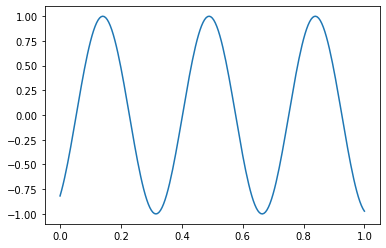

In [11]:
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

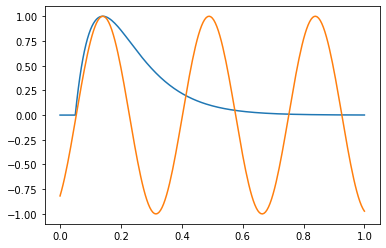

In [12]:
plt.plot(ftime, env_true)
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

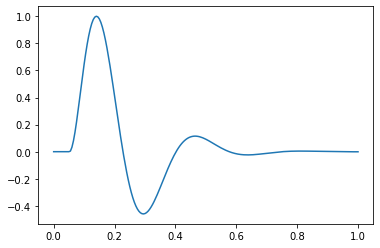

In [13]:
plt.plot(ftime, ftrue)

### True Noise

In [14]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (n + 1, 1))

### Output

In [15]:
# Padding and applying the FFT
spikepad1 = np.hstack((spikedat1, np.zeros((num_filt, k, 1))))
spikepad2 = np.hstack((spikedat2, np.zeros((num_filt, k, 1))))
spikepad3 = np.hstack((spikedat3, np.zeros((num_filt, k, 1))))

fpad = np.vstack((ftrue.reshape((k + 1, 1)), np.zeros((n, 1))))

spikefft1 = np.fft.rfft(spikepad1, axis = 1)
spikefft2 = np.fft.rfft(spikepad2, axis = 1)
spikefft3 = np.fft.rfft(spikepad3, axis = 1)
spikef = [spikefft1, spikefft2, spikefft3]

fftlen1 = np.shape(spikefft1)[1]
fftlen2 = np.shape(spikefft2)[1]
fftlen3 = np.shape(spikefft3)[1]
fftlen = [fftlen1, fftlen2, fftlen3]

spikefft = [spikef[j].reshape(num_mach, batch_size, fftlen[j], 1) for j in range(3)]
spikefft = [[spikefft[j][i] for j in range(3)] for i in range(num_mach)]

f_fft = np.fft.rfft(fpad, axis = 0)

fftmul = [[spikefft[j][i] * f_fft for i in range (3)] for j in range(num_mach)]

fftsum = [[fftmul[j][i] for j in range(num_mach)] for i in range(3)]
fftsummach = [np.sum(fftsum[i], axis = 0) for i in range(3)]

ynonoise = [np.fft.irfft(np.sum(fftsummach[i], axis = 0), k + n + 1, axis = -2)[: n + 1] for i in range(3)]
yvel = [(ynonoise[i] + noise_vec).reshape(n + 1, 1) for i in range(3)]

spikefft = jnp.asarray(spikefft)
yvel = jnp.asarray(yvel)

In [16]:
# Showing equals the raw convolution
yffttest = np.convolve(spikedat1.flatten(), ftrue.flatten())[:n + 1] + noise_vec.flatten()

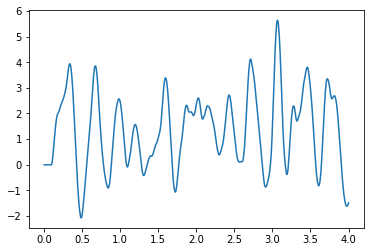

In [17]:
plt.plot(ytime, ynonoise[0].flatten())

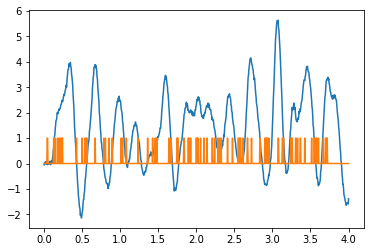

In [18]:
plt.plot(ytime, yvel[0].flatten())
plt.plot(ytime, spikedat1.flatten())

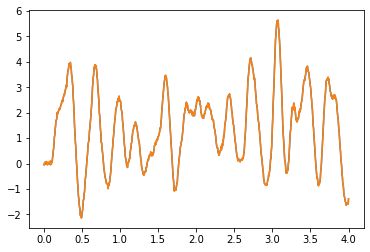

In [19]:
plt.plot(ytime, yffttest.flatten())
plt.plot(ytime, yvel[0].flatten())

In [20]:
print(spikefft[0][0].shape)
print(ytime.shape)
print(yvel[0].shape)

(1, 501, 1)
(801, 1)
(801, 1)


# ELBO 

In [21]:
Diag = vmap(jnp.diag)

In [22]:
@jit
def Set(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [23]:
Setoff = vmap(Set, in_axes=(0, None, 0,))

In [24]:
@jit
def KL_Term(L_Matrix, V_Vector, Num_Filt, M):
  return  0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - Num_Filt * M)

In [25]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [26]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [27]:
@jit
def Likelihoods(Predictions, Velocity, Sigma_n, N):
  return - 0.5 * ((N + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Velocity - Predictions)**2, axis = -2)/(Sigma_n ** 2))

In [28]:
Likely = vmap(Likelihoods, in_axes=(0, 0, None, 0,))

In [42]:
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Number_F, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2, Narr,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys):

  # Creating lag and z-vector         
  Lag = Lag ** 2.0
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag) + Lag

  # Creating the L-matrix
  D = Diag(jnp.exp(L_Diag))

  L_Matrix = D.at[:, Indices[0], Indices[1]].set(L_ODiag)

  # KL term
  KL = 0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - Batch_Size * M)

  # Expectation term
  Thetas = random.normal(Subkeys[0], (Number_F, Batch_Size, 1, Num_Base)) * (1.0 / Ell)

  Taus = random.uniform(Subkeys[1], (Number_F, Batch_Size, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Batch_Size, Num_Base, 1))

  Constant = (Sigma_f * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f, Ell)
  Knm = Squared_exp(F_Time, ZT, Sigma_f, Ell)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))

  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Batch_Size, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise, TauDiff, Lag)

  F_Fft0 = jnp.fft.rfft(F_Samples, n = N0 + K + 1, axis = -2)
  # F_Fft1 = jnp.fft.rfft(F_Samples, n = N1 + K + 1, axis = -2)
  # F_Fft2 = jnp.fft.rfft(F_Samples, n = N2 + K + 1, axis = -2)

  Filter_Out0 = jnp.fft.irfft(F_Fft0 * Spike_Fft[0], N0 + K + 1, axis = -2)[:, :, : N0 + 1].sum(axis = 1)
  # Filter_Out1 = jnp.fft.irfft(F_Fft1 * Spike_Fft[1], N1 + K + 1, axis = -2)[:, :, : N1 + 1].sum(axis = 1)
  # Filter_Out2 = jnp.fft.irfft(F_Fft2 * Spike_Fft[2], N2 + K + 1, axis = -2)[:, :, : N2 + 1].sum(axis = 1)

  Filter0 = lax.psum(Filter_Out0, axis_name="machs")
  # Filter1 = lax.psum(Filter_Out1, axis_name="machs")
  # Filter2 = lax.psum(Filter_Out2, axis_name="machs")

  Filter = jnp.asarray([Filter0]) #Filter1, Filter2])

  Likelihood0 = Likely(Filter, Velocity, Sigma_n, Narr).sum(axis=0)

  KL = lax.psum(KL, axis_name="machs")
  Exp = jnp.mean(Likelihood0)
                  
  return (KL-Exp)/(Num_Filt * jnp.sum(Narr) + 1)

In [43]:
PNeg = pmap(Neg_ELBO, axis_name = "machs", in_axes=(0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, None, None, None, None, None, None, None, None, None, None, 0, None, None, 0,),
            static_broadcasted_argnums = range(10, 19))

In [50]:
yvel = jnp.asarray([yvel[0]])
narr = jnp.asarray([n])

test_number_f = 15
test_num_base = 100
test_m = int(20)

test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 1 + 4 * num_mach)
test_subkeys = np.asarray(test_subkeys).astype(np.uint32).reshape(num_mach, 4, 2)

test_sigma_f = 2.0 * np.ones((num_mach, batch_size, 1, 1))# np.arange(num_mach * batch_size).reshape(num_mach, batch_size, 1, 1)
test_ell_f = 0.7 * np.ones((num_mach, batch_size, 1, 1))
test_sigma_n = 0.01
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_mach, batch_size, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = 5.0 * np.ones((num_mach, batch_size, test_m, 1))
test_l_diag = np.ones((num_mach, batch_size, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_mach, batch_size, 1))
test_trise = 0.02 * np.ones((num_mach, batch_size, 1, 1))
test_tdiff = 0.03 * np.ones((num_mach, batch_size, 1, 1))
test_lag = 0.01 * np.ones((num_mach, batch_size, 1, 1))
test_indices = np.tril_indices(test_m, -1)

In [51]:
@partial(jit, static_argnums = range(10, 19))
def Return(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Number_F, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2, Narr, 
              Indices, Spike_Fft, Velocity, F_Time, Subkeys):

  return PNeg(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Number_F, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2, Narr, 
              Indices, Spike_Fft, Velocity, F_Time, Subkeys)[0]

In [52]:
testelb = Return(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag,
              test_l_odiag, test_trise, test_tdiff, test_lag, test_number_f, test_num_base,
              test_m, num_filt, batch_size, k, n, n, n, narr, test_indices, spikefft, yvel, 
              ftime, test_subkeys)

In [53]:
print(testelb)

19829.289525232853


In [54]:
Grad_Bound = value_and_grad(Return, argnums = range(10))

In [55]:
testval, testgrad = Grad_Bound(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag,
              test_l_odiag, test_trise, test_tdiff, test_lag, test_number_f, test_num_base,
              test_m, num_filt, batch_size, k, n, n, n, narr, test_indices, spikefft, yvel, 
              ftime, test_subkeys)

In [56]:
print(testval)

19829.289525232853


# Training the Model

In [60]:
def AdamOpt(Init_Params, Number_F, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, 
              N0, N1, N2, Narr, Indices, Spike_Fft, Velocity, F_Time,   
              Coarse_Schedule = [400, 400, 700], Mid_Schedule = [13500], Fine_Iters = 5000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = np.zeros(20000)
  Step = 0
  Key = random.PRNGKey(1)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  Params = Init_Params

  Opt_InitC, Opt_UpdateC, Get_ParamsC = jeo.adam(1e-2)
  Opt_InitM, Opt_UpdateM, Get_ParamsM = jeo.adam(1e-3)
  Opt_InitF, Opt_UpdateF, Get_ParamsF = jeo.adam(1e-4)

  for i in tqdm(range(len(Coarse_Schedule))):
    OptState = Opt_InitC(Params)
    for j in range(Coarse_Schedule[i]):
      print(Step)
      Value, Grads = Grad_Bound(*Params, Number_F, Num_Base, M, Num_Filt, Batch_Size, 
                                K, N0, N1, N2, Narr, Indices, Spike_Fft, Velocity, F_Time, Subkeys)
      OptState = Opt_UpdateC(j, Grads, OptState)
      Params = Get_ParamsC(OptState)
      Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
      Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
      ELBO_History[Step] = -Value
      Step += 1

  for i in tqdm(range(len(Mid_Schedule))):
    OptState = Opt_InitM(Params)
    for j in range(Mid_Schedule[i]):
  
      Value, Grads = Grad_Bound(*Params, Number_F, Num_Base, M, Num_Filt, Batch_Size, 
                                K, N0, N1, N2, Narr, Indices, Spike_Fft, Velocity, F_Time, Subkeys)
      OptState = Opt_UpdateM(j, Grads, OptState)
      Params = Get_ParamsM(OptState)
      Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
      Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
      ELBO_History[Step] = -Value
      Step += 1

  OptState = Opt_InitF(Params)
  for j in tqdm(range(Fine_Iters)):

    Value, Grads = Grad_Bound(*Params, Number_F, Num_Base, M, Num_Filt, Batch_Size, 
                                K, N0, N1, N2, Narr, Indices, Spike_Fft, Velocity, F_Time, Subkeys)
    OptState = Opt_UpdateF(j, Grads, OptState)
    Params = Get_ParamsF(OptState)
    Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
    Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
    ELBO_History[Step] = -Value
    Step += 1

  return Params, ELBO_History 

In [61]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 1.0 * jnp.ones((num_mach, batch_size, 1, 1))
iell = 0.002 * jnp.ones ((num_mach, batch_size, 1, 1))
isigma_n = 0.000000005
itrise = np.sqrt(0.05) * jnp.ones((num_mach, batch_size, 1, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))

# Variational parameters
num_f = 15
num_b = 100
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_mach, batch_size, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = 0.01 * random.normal(subkeys[-3], (num_mach, batch_size, num_ind, 1))
il_diag = 0.01 * random.normal(subkeys[-2], (num_mach, batch_size, num_ind))
il_odiag = 0.1 * random.normal(subkeys[-1], (num_mach, batch_size, int((num_ind ** 2 - num_ind) / 2)))
indices = jnp.asarray(jnp.tril_indices(num_ind, -1))

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, *opt_subkey = random.split(opt_key, 1 + 4 * num_mach)
opt_subkey = np.asarray([opt_subkey[i:i+4] for i in range(num_mach)]).astype(np.uint32)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, num_filt, batch_size, k, n, n, n, narr, indices, spikefft, yvel, ftime)

In [62]:
fparams, elbo_history = AdamOpt(params, num_f, num_b, num_ind, num_filt, num_mach, batch_size,
                                  k, n, n, n, narr, indices, spikefft, yvel, ftime)

  0%|          | 0/3 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 33%|███▎      | 1/3 [00:56<01:52, 56.20s/it]

399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648


 67%|██████▋   | 2/3 [01:33<00:45, 45.04s/it]

799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1

100%|██████████| 3/3 [02:48<00:00, 56.33s/it]


1499


100%|██████████| 5000/5000 [08:10<00:00, 10.18it/s]


In [63]:
print(Return(*params, num_f, num_b, *consparams, opt_subkey))

1.1679283767640114e+17


In [64]:
print(Return(*fparams, num_f, num_b, *consparams, opt_subkey))

-1.4938680359858987


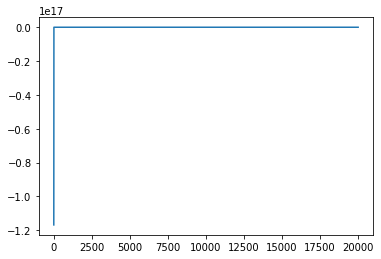

In [65]:
plt.plot(elbo_history[:])

In [66]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [67]:
@jit
def Set(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [68]:
PDiag = pmap(Diag)

In [69]:
PSet = pmap(Set, in_axes=(0, None, 0,))

In [70]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = PDiag(np.exp(il_diag))
print(il_diag.shape)
print(idz.shape)
il_matrix = PSet(idz, indices, il_odiag)


flag = flag ** 2

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag) + flag

fd = PDiag(np.exp(fl_diag))
fl_matrix = PSet(fd, indices, fl_odiag)
print(fd.shape)
print(fl_matrix.shape)

(1, 1, 20)
(1, 1, 20, 20)
(1, 1, 20, 20)
(1, 1, 20, 20)


In [71]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

fsigma_ff = fsigma_f.reshape(num_filt, 1)
fellf = fell.reshape(num_filt, 1)
fz_vectorf = fz_vector.reshape(num_filt, num_ind, 1)
fv_vectorf = fv_vector.reshape(num_filt, num_ind, 1)
fl_matrixf = fl_matrix.reshape(num_filt, num_ind, num_ind)
ftrisef = ftrise.reshape(num_filt, 1)
ftaudifff = ftaudiff.reshape(num_filt, 1)
flagf = flag.reshape(num_filt, 1)

In [72]:
print(len(spikefft))

1


In [73]:
spikeffta = [np.asarray([spikefft[i][j] for i in range(num_mach)]) for j in range(3)]

In [74]:
spikefftf = [spikeffta[i].reshape(num_filt, fftlen[i], 1) for i in range(3)]

In [75]:
print(len(spikefftf))
print(spikefftf[0].shape)

3
(1, 501, 1)


In [76]:
print(fsigma_ff)

[[0.46658407]]


In [77]:
print(fellf)

[[0.08039307]]


In [78]:
print(fsigma_n)

0.051144723271937496


In [79]:
print(ftrisef)

[[0.23673838]]


In [80]:
print(ftaudifff)

[[-0.24981873]]


In [81]:
print(flagf)

[[0.05844234]]


## Variational Predictions

In [82]:
fpred_points = ftime.copy()

In [83]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
ibzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)
ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [84]:
scfsigmaf = fsigma_ff[:, None]
scfellf = fellf[:, None]
scftrisef = ftrisef[:, None]
scftaudifff = ftaudifff[:, None]
scflagf = flagf[:, None]

fkmm = Squared_exp(fz_vectorf, fz_vectorf.transpose(0, 2, 1), scfsigmaf, scfellf)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vectorf, fpred_points.T, scfsigmaf, scfellf)
fbzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fbzastT = fbzast.transpose(0, 2, 1)
fpredenv = AlpEnvelope(fpred_points, scftrisef, scftaudifff, scflagf)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vectorf)

fkastast = Squared_exp(fpred_points, fpred_points.T, scfsigmaf, scfellf)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrixf @ fl_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

In [85]:
print(imeanpred.shape)

(1, 201, 1)


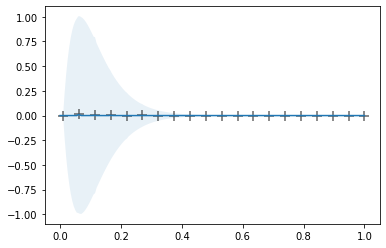

In [86]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)
index = 2
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

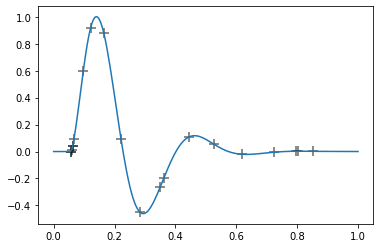

In [87]:
predindenv = AlpEnvelope(fz_vectorf, scftrisef, scftaudifff, scflagf)

plt.plot(fpred_points, fmeanpred[index])
s2 = np.sqrt(np.diag(fcovpred[index]))
fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

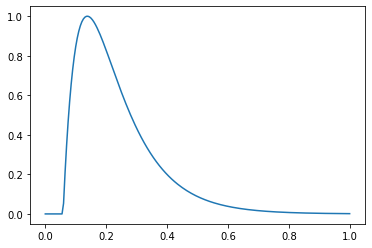

In [88]:
envelopes = AlpEnvelope(ftime, scftrisef, scftaudifff, scflagf)
for i in envelopes:
  plt.plot(ftime, i)

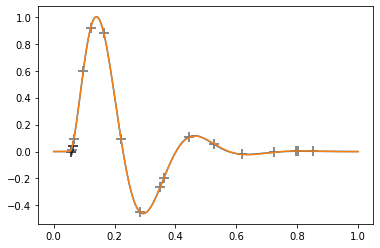

In [89]:
for index in range(num_filt):
  plt.plot(fpred_points, fmeanpred[index])
  s2 = np.sqrt(np.diag(fcovpred[index]))
  fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
  plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
  #plt.xlim([ftime[0], ftime[-1]])

plt.plot(ftime, ftrue)

In [90]:
def OUTconvolve(Filters, K, N, Spike_FFT):
  Pad = np.hstack((Filters, np.zeros((num_filt, N, 1))))
  Pred_fft = np.fft.rfft(Pad, axis = -2)
  Pred_sum = np.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = np.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [91]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, k, n, spikefftf[0])
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2, k, n, spikefftf[0])
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2, k, n, spikefftf[0])

In [97]:
fs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

fmeanpredict = OUTconvolve(fmeanpred, k, n, spikefftf[0])
print(fmeanpredict.shape)
fmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2, k, n, spikefftf[0])
fmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2, k, n, spikefftf[0])

(801, 1)


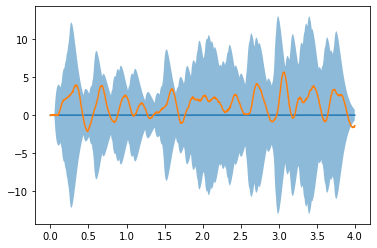

In [98]:
plt.plot(ytime, imeanpredict)
plt.plot(ytime, yvel[0])
plt.fill_between(ytime.flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

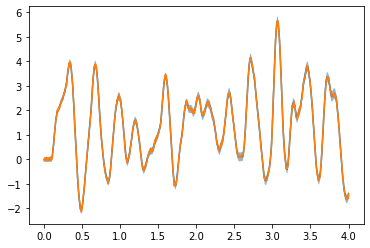

In [99]:
plt.plot(ytime, fmeanpredict)
plt.plot(ytime, yvel[0])
plt.fill_between(ytime.flatten(), fmeanpredictns2.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)

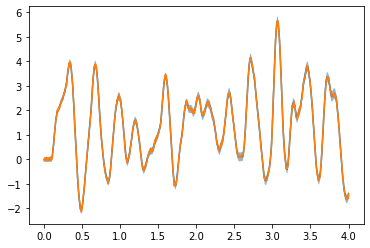

In [100]:
ytesttru = yvel[:3000]
ytimetru = ytime[:3000]
fmeanpredicttru = fmeanpredict[:3000]
fmeanpredictns2tru = fmeanpredictns2[:3000]
fmeanpredictps2tru = fmeanpredictps2[:3000]
plt.plot(ytimetru, fmeanpredicttru)
plt.plot(ytimetru, ytesttru[0])
plt.fill_between(ytimetru.flatten(), fmeanpredictns2tru.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2tru.flatten() + 2 * fsigma_n, alpha = 0.5)